In [1]:
import sys
from pathlib import Path

# Add the src directory to the Python path
sys.path.append(str(Path().resolve().parent / "src"))

# Import necessary libraries
import torch
import shap
import itertools
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from ipywidgets import interact, FloatSlider

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import glob
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from config import MODEL_DIR, MODEL_NAME, DEVICE
from model.architecture_config import get_multimodal_cnn_model
from model.train import calculate_metrics, LandslideDataset
import config

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [2]:
# load data into device
device = torch.device(config.DEVICE)

# Create dataset with data loaded into memory
print("Loading dataset into memory...")
dataset = LandslideDataset(
    image_dir=config.PROCESSED_TRAIN_IMAGE_DIR,
    csv_path=config.TRAIN_CSV_PATH,
    device=device
)

Loading dataset into memory...


Loading images: 100%|██████████| 7147/7147 [00:03<00:00, 2228.13it/s]

Loaded 7147 valid images out of 7147
Total memory usage: 1.31 GB


In [3]:
# Load the first model checkpoints from the cross-validation folder
model_dir = MODEL_DIR / MODEL_NAME
model_path = glob.glob(str(model_dir / f"{MODEL_NAME}_*.pth"))[0]

print(f"Loading model from {model_path}")
model = get_multimodal_cnn_model(dropout=0.0, final_dropout=0.0).to(device)
checkpoint = torch.load(model_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

targets = checkpoint["val_targets"]
y_preds = checkpoint["final_val_predictions"]

# load performance related information

Loading model from D:\Landslide-Image-Classification\models\landslide_MMCNN_V4\landslide_MMCNN_V4_0.pth


accuracy score: 0.9594405594405594
F1 score: 0.8941605839416058
Confusion matrix
[[1127   41]
 [  17  245]]
model 1 AUC score: 0.9903599811774547
F1-optimal threshold:  0.41 F1:  0.8953068592057761


(0.9594405594405594,
 0.9351145038167938,
 0.8566433566433567,
 0.8941605839416058)

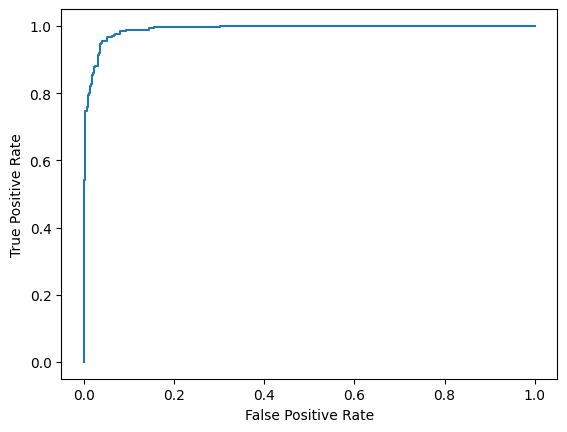

In [4]:
print(f'accuracy score: {checkpoint["val_accuracies"][-1]}')
print(f'F1 score: {checkpoint["val_f1s"][-1]}')
cf_mat = confusion_matrix(targets,  y_preds> 0.5)
print('Confusion matrix')
print(cf_mat)

plot_roc_curve(targets, y_preds)
print(f'model 1 AUC score: {roc_auc_score(targets, y_preds)}')

calculate_metrics(targets, y_preds, f1_optimal=True)

In [5]:
# extract mistakes
mistakes_bool = targets != (y_preds > 0.5)
mistakes_idx = checkpoint["val_idx"][mistakes_bool]
print("Number of miss-classified images: ", len(mistakes_idx))


# Create subsets from the same dataset
train_subset = Subset(dataset, checkpoint["train_idx"])
error_subset = Subset(dataset, mistakes_idx)

# Load entire train subset as a single batch
train_images, train_targets = next(iter(DataLoader(
    train_subset,
    batch_size=200,
    shuffle=True,
    num_workers=0,
    generator=torch.Generator().manual_seed(config.SEED)
)))

# Load entire error subset as a single batch
error_images, error_targets = next(iter(DataLoader(
    error_subset,
    batch_size=len(error_subset),
    shuffle=False,
    num_workers=0
)))

Number of miss-classified images:  58


In [6]:
# calculate SHAP values for each misclassified image
e = shap.DeepExplainer(model, train_images)
shap_values = e.shap_values(error_images, check_additivity=False)

interactive(children=(FloatSlider(value=1.0, description='SHAP transparency', max=1.0), Output()), _dom_classe…

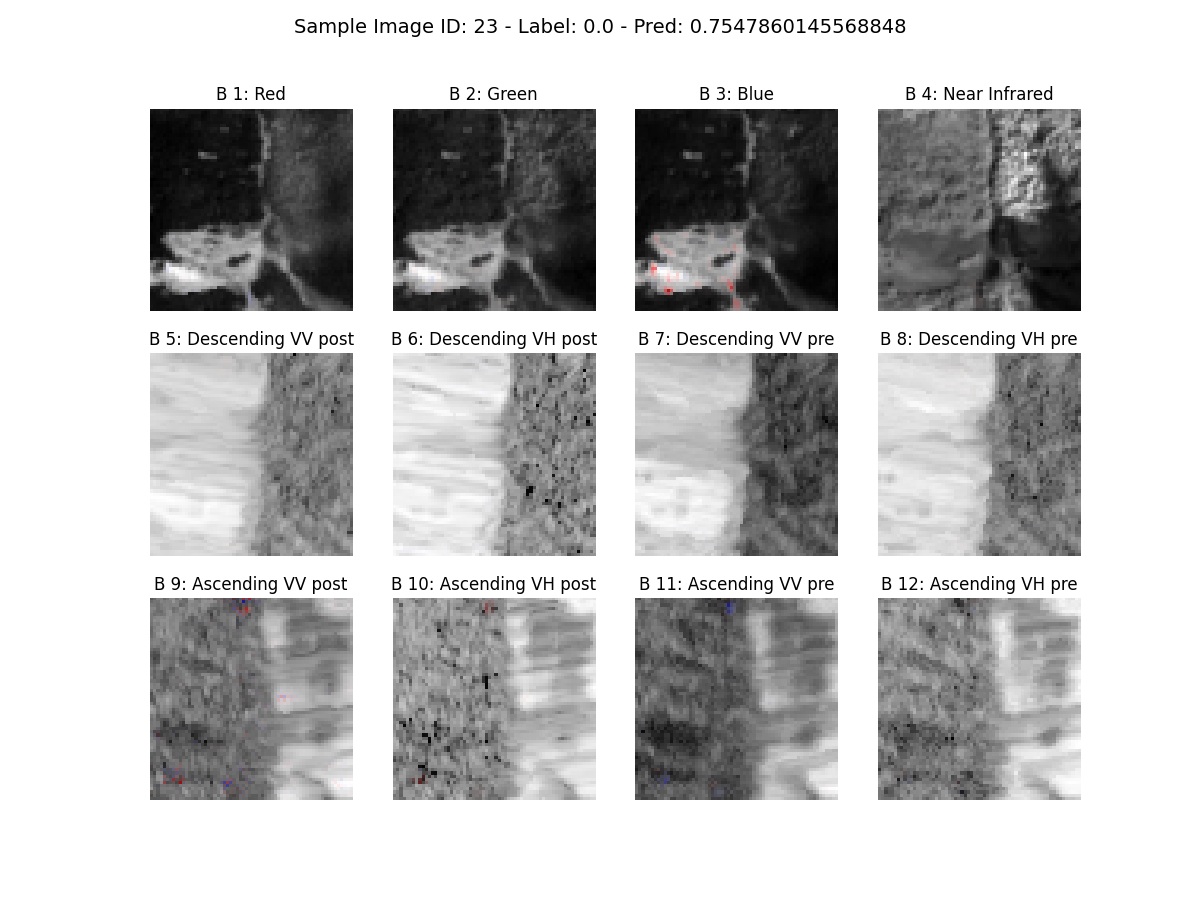

In [91]:
%matplotlib widget

# Band descriptions
band_descriptions = [
    "Red", "Green", "Blue", "Near Infrared",
    "Descending VV post", "Descending VH post",
    "Descending VV pre", "Descending VH pre",
    "Ascending VV post", "Ascending VH post",
    "Ascending VV pre", "Ascending VH pre"
]

# SHAP visualization settings
vmin, vmax = -0.1, 0.1
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap('seismic')

# Data prep (as before)
example_id = 23
image = error_images[example_id]
shap_values_example = shap_values[example_id]
label = targets[mistakes_bool][example_id]
y_pred = y_preds[mistakes_bool][example_id]

# Precompute RGB channels
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
fig.suptitle(f"Sample Image ID: {example_id} - Label: {label} - Pred: {y_pred}", fontsize=14)

rgba_overlays = []
overlay_images = []

for band in range(12):
    row, col = divmod(band, 4)
    
    # Background image
    axes[row, col].imshow(image[band].cpu().numpy(), cmap='gray')
    axes[row, col].set_title(f"B {band + 1}: {band_descriptions[band]}")
    axes[row, col].axis('off')
    
    # Precompute SHAP normalized and RGB values
    shap_band = shap_values_example[band, :, :, 0]
    shap_norm = norm(shap_band)
    rgba = cmap(shap_norm)
    
    # Store RGB and |shap| for alpha modulation
    rgb = rgba[..., :3]  # shape (H, W, 3)
    abs_shap = np.clip(np.abs(shap_band) / vmax, 0, 1)  # shape (H, W)
    
    # Compose RGBA for initial alpha
    initial_alpha = 1
    rgba_full = np.dstack((rgb, initial_alpha * abs_shap))
    
    # Plot and store overlay
    overlay = axes[row, col].imshow(rgba_full)
    rgba_overlays.append((rgb, abs_shap))  # keep for dynamic update
    overlay_images.append(overlay)

# Update only alpha channel
def update(alpha=1):
    for i in range(12):
        rgb, abs_shap = rgba_overlays[i]
        new_rgba = np.dstack((rgb, alpha * abs_shap))
        overlay_images[i].set_data(new_rgba)
    fig.canvas.draw_idle()

# Create interactive slider
interact(update, alpha=FloatSlider(value=1, min=0.0, max=1.0, step=0.1, description="SHAP transparency"));


In [29]:
# extract correct labeled
correct_bool = targets == (y_preds > 0.5)
correct_idx = checkpoint["val_idx"][correct_bool][:50]


# Create subsets from the same dataset
train_subset = Subset(dataset, checkpoint["train_idx"])
correct_subset = Subset(dataset, correct_idx)

# Load entire train subset as a single batch
train_images, train_targets = next(iter(DataLoader(
    train_subset,
    batch_size=200,
    shuffle=True,
    num_workers=0,
    generator=torch.Generator().manual_seed(config.SEED)
)))

# Load entire error subset as a single batch
correct_images, correct_targets = next(iter(DataLoader(
    correct_subset,
    batch_size=len(correct_subset),
    shuffle=False,
    num_workers=0
)))

# calculate SHAP values for each misclassified image
e = shap.DeepExplainer(model, train_images)
correct_shap_values = e.shap_values(correct_images, check_additivity=False)

interactive(children=(FloatSlider(value=1.0, description='SHAP transparency', max=1.0), Output()), _dom_classe…

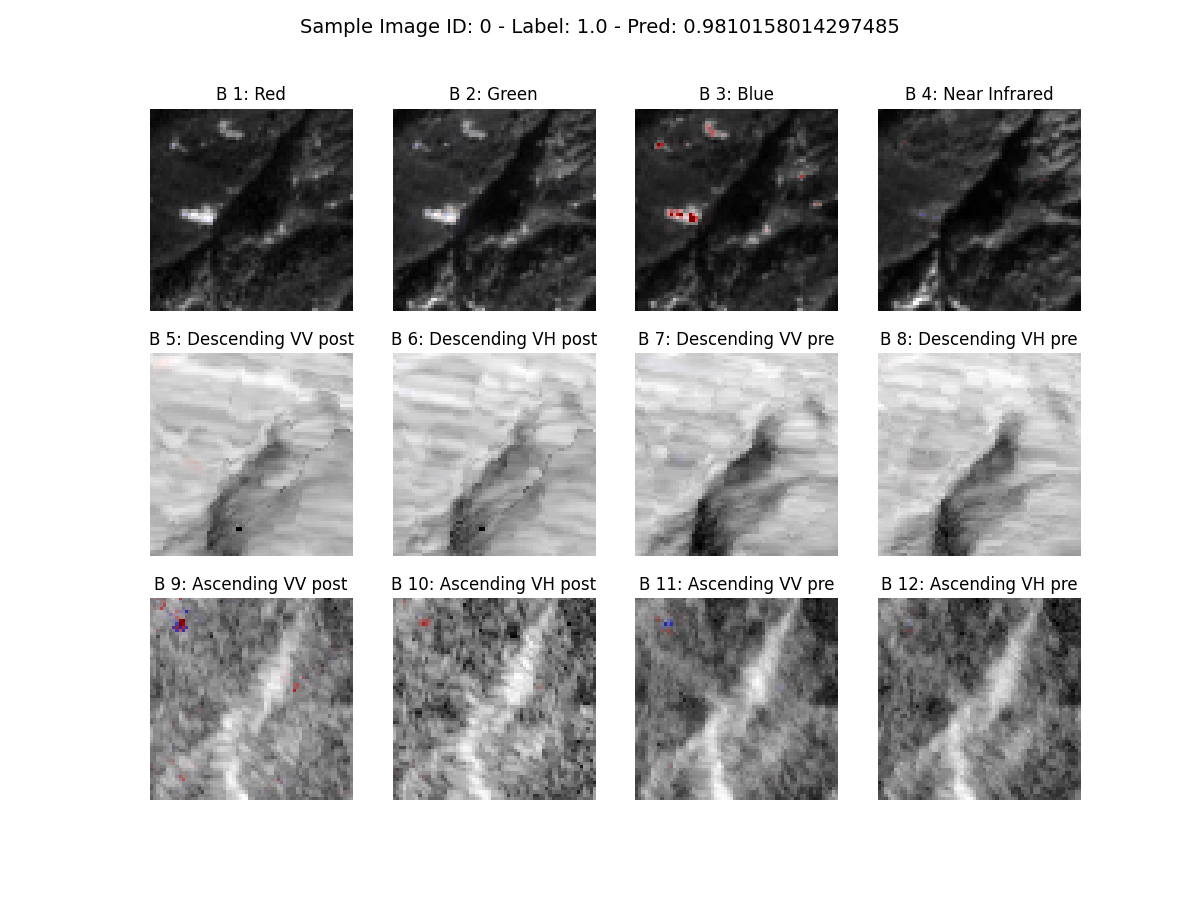

In [86]:
%matplotlib widget

# Band descriptions
band_descriptions = [
    "Red", "Green", "Blue", "Near Infrared",
    "Descending VV post", "Descending VH post",
    "Descending VV pre", "Descending VH pre",
    "Ascending VV post", "Ascending VH post",
    "Ascending VV pre", "Ascending VH pre"
]

# SHAP visualization settings
vmin, vmax = -0.1, 0.1
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap('seismic')

# Data prep (as before)
example_id = np.random.randint(len(correct_images))
image = correct_images[example_id]
shap_values_example = correct_shap_values[example_id]
label = targets[correct_bool][example_id]
y_pred = y_preds[correct_bool][example_id]

# Precompute RGB channels
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
fig.suptitle(f"Sample Image ID: {example_id} - Label: {label} - Pred: {y_pred}", fontsize=14)

rgba_overlays = []
overlay_images = []

for band in range(12):
    row, col = divmod(band, 4)
    
    # Background image
    axes[row, col].imshow(image[band].cpu().numpy(), cmap='gray')
    axes[row, col].set_title(f"B {band + 1}: {band_descriptions[band]}")
    axes[row, col].axis('off')
    
    # Precompute SHAP normalized and RGB values
    shap_band = shap_values_example[band, :, :, 0]
    shap_norm = norm(shap_band)
    rgba = cmap(shap_norm)
    
    # Store RGB and |shap| for alpha modulation
    rgb = rgba[..., :3]  # shape (H, W, 3)
    abs_shap = np.clip(np.abs(shap_band) / vmax, 0, 1)  # shape (H, W)
    
    # Compose RGBA for initial alpha
    initial_alpha = 1
    rgba_full = np.dstack((rgb, initial_alpha * abs_shap))
    
    # Plot and store overlay
    overlay = axes[row, col].imshow(rgba_full)
    rgba_overlays.append((rgb, abs_shap))  # keep for dynamic update
    overlay_images.append(overlay)

# Update only alpha channel
def update(alpha=1):
    for i in range(12):
        rgb, abs_shap = rgba_overlays[i]
        new_rgba = np.dstack((rgb, alpha * abs_shap))
        overlay_images[i].set_data(new_rgba)
    fig.canvas.draw_idle()

# Create interactive slider
interact(update, alpha=FloatSlider(value=1, min=0.0, max=1.0, step=0.1, description="SHAP transparency"));
